In [2]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from other_hough_transform import old_method_tracks
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
import pickle
import scienceplots
plt.style.use(['science', 'grid', 'bright'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})

ValueError: Key text.latex.preamble: Could not convert ['\\usepackage{amsmath} \\usepackage{amssymb} \\usepackage{siunitx}'] to str

In [ ]:
file_path = r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\test_import_root\data_0000\data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 51.28% of all events


In [1]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False, sampling = 10, angle_sampling = 240):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    chi_squares = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0], leave = True, desc = 'events'):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)
            
        if track.reduced_chi2() is not None:
            chi_squares.append(track.reduced_chi2())

    return tracks, chi_squares
    

In [2]:
# getting tracks
# tracks, chi_squares = create_tracks(df_hits.iloc[15000:16000])
# with open('hough_parameters_tracks.pkl', 'wb') as outp:
    # pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)
with open('hough_parameters_tracks.pkl', 'rb') as inp:
    tracks = pickle.load(inp)
total_events = len(tracks)

NameError: name 'pickle' is not defined

In [ ]:
from timeit import default_timer as timer
cell_sampling = [1, 5, 10, 15, 20]
angle_sampling = [50, 100, 150, 200, 250]

## study of impact of angle sampling for given cell samplings
ratios_for_cells = []
timings_for_cells = []
for_cells_angle_sampling = np.linspace(10, 250, 60, dtype = int)
for cs in tqdm(cell_sampling, desc = 'for cell sampling', position=0, leave = True):
    ratios = []
    timings = []
    for a in tqdm(for_cells_angle_sampling, desc = 'angle sampling', position=1, leave = False):
        start = timer()
        for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
            t.find_track(cs, a)
        end = timer()
        ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
        timings.append((end - start) * 1000 / total_events)
    ratios_for_cells.append(ratios)
    timings_for_cells.append(timings)
with open('hough_parameters_for_cells2.pkl', 'wb') as outp:
    pickle.dump([cell_sampling, ratios_for_cells, timings_for_cells, for_cells_angle_sampling], outp, pickle.HIGHEST_PROTOCOL)

## study of impact of cell sampling for given angle samplings
ratios_for_angles = []
timings_for_angles = []
for_angles_cell_sampling = np.linspace(1, 20, 20, dtype = int)
for a in tqdm(angle_sampling, desc = 'for angle sampling', position=0, leave = True):
    ratios = []
    timings = []
    for cs in tqdm(for_angles_cell_sampling, desc = 'cell sampling', position=1, leave = False):
        start = timer()
        for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
            t.find_track(cs, a)
        end = timer()
        ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
        timings.append((end - start) * 1000 / total_events)
    ratios_for_angles.append(ratios)
    timings_for_angles.append(timings)
with open('hough_parameters_for_angles2.pkl', 'wb') as outp:
    pickle.dump([angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling], outp, pickle.HIGHEST_PROTOCOL)

## old Hough transform method
start = timer()
old_tracks = []
for t in tqdm(tracks, desc = 'old method', leave = True):
    hitsX = t.x.hits.copy()
    hitsY = t.y.hits.copy()
    outx, tx, index_x = old_method_tracks(hitsX)
    outy, ty, index_y = old_method_tracks(hitsY)
    old_t = Track3D()
    old_t.x = Track(hitsX, tx, outx, 0)
    old_t.y = Track(hitsY, ty, outy, 0)
    old_tracks.append(old_t)
stop = timer()
ratio_for_old = len([tr for tr in old_tracks if tr.is_good_2D_fit()]) / total_events
timing_for_old = (stop - start) * 1000 / total_events

## Kalman filter method
start = timer()
for t in tqdm(tracks, desc = 'Kalman', leave = True):
    t.kalman_filter()
stop = timer()
ratio_Kalman = len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events
timing_Kalman = (stop - start) * 1000 / total_events

with open('hough_parameters_for_cells2.pkl', 'rb') as inp:
    [cell_sampling, ratios_for_cells, timings_for_cells, for_cells_angle_sampling] = pickle.load(inp)
with open('hough_parameters_for_angles2.pkl', 'rb') as inp:
    [angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling] = pickle.load(inp)

for cell sampling:   0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt: 

Kalman efficiency = 0.099


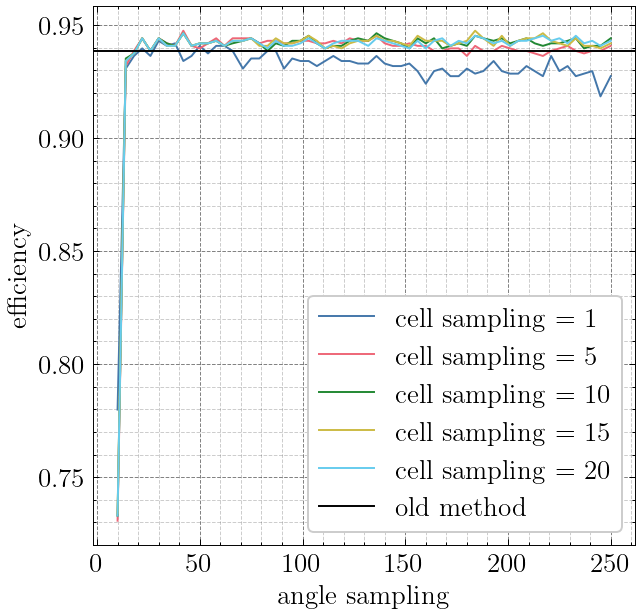

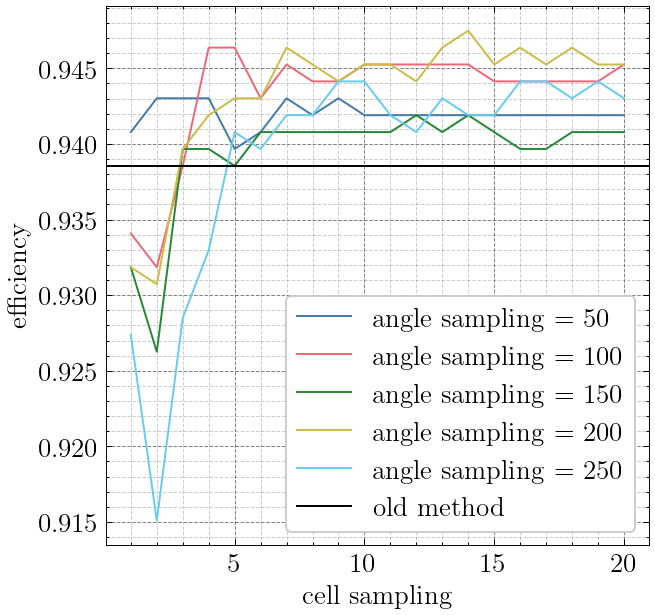

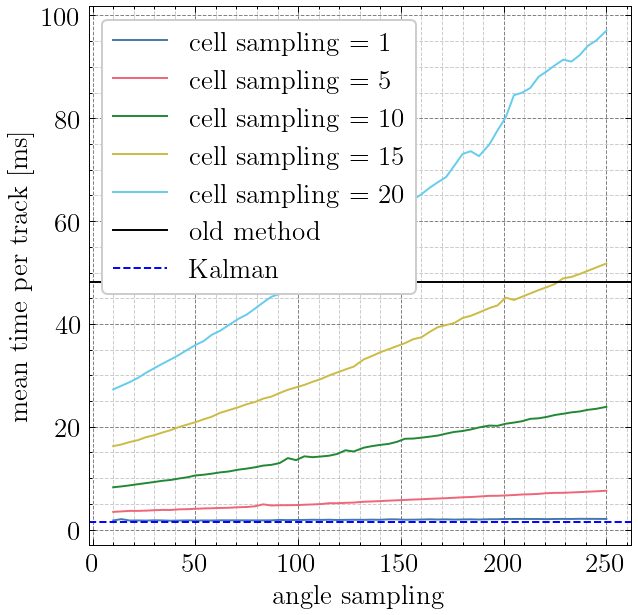

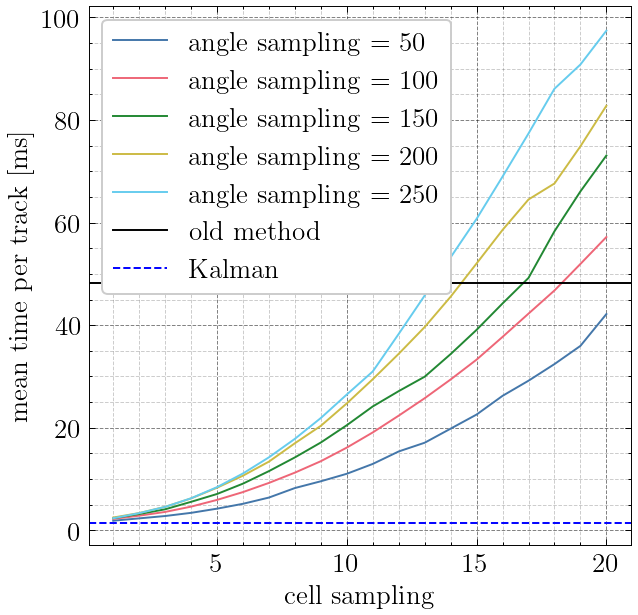

In [ ]:
print('Kalman efficiency = {:.3f}'.format(ratio_Kalman))
# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.figure(figsize=(5, 5))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, ratios_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.axhline(ratio_for_old, 0, 1, c = 'k', label = 'old method')
# plt.axhline(ratio_Kalman, 0, 1, c='b', linestyle = '--', label='Kalman')
plt.xlabel('angle sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_ratio_for_cells2.pdf')

plt.figure(figsize=(5, 5))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, ratios_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.axhline(ratio_for_old, 0, 1, c = 'k', label='old method')
# plt.axhline(ratio_Kalman, 0, 1, c='b', linestyle = '--', label='Kalman')
plt.xlabel('cell sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_ratio_for_angles2.pdf')

# fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.figure(figsize=(5, 5))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, timings_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.axhline(timing_for_old, 0, 1, c = 'k', label = 'old method')
plt.axhline(timing_Kalman, 0, 1, c = 'b', linestyle = '--', label = 'Kalman')
plt.xlabel('angle sampling')
plt.ylabel('mean time per track [ms]')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_timing_for_cells2.pdf')

plt.figure(figsize=(5, 5))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, timings_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.axhline(timing_for_old, 0, 1, c = 'k', label='old method')
plt.axhline(timing_Kalman, 0, 1, c = 'b', linestyle = '--', label = 'Kalman')
plt.xlabel('cell sampling')
plt.ylabel('mean time per track [ms]')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_timing_for_angles2.pdf')


Text(0.5, 0, '$\\chi^2_\\mathrm{red}$')

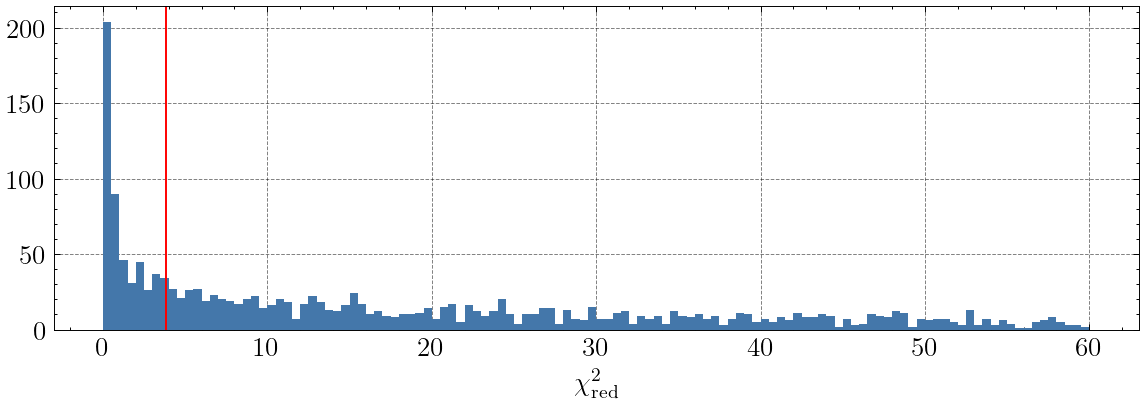

In [ ]:
chis = [t.x.reduced_chi2 for t in tracks]
chis.extend([t.y.reduced_chi2 for t in tracks])
plt.figure(figsize=(10, 3))
plt.hist(chis, bins = 120, range = [0, 60])
plt.axvline(3.841, 0, 1, c='r')
plt.xlabel(r'$\chi^2_\mathrm{red}$')